# 单隐层神经网络#
** 学习内容：**
- 搭建一个单隐层二分类神经网络：
    - 使用非线性激活神经元
    - 计算交叉熵损失
    - 计算前向传播与反向传播

## 需要调用的库：#
- numpy：常用的科学计算库
- sklearn：进行简单高效的数据挖掘与分析
- matplotlib：用于数据可视化
- planar_utils：提供本例所需的一些函数
- testCases_v2：提供测试用例

**设置一个随机种子以便结果复现**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from depends.testCases_v2 import *
import sklearn
import sklearn.datasets
import sklearn.linear_model
from depends.planar_utils import plot_decision_boundary, sigmoid, load_planar_dataset, load_extra_datasets

%matplotlib inline

np.random.seed(1) 

## 数据集#
本次的数据是二维平面上的点集，共两类，通过matplotlib可视化可见分布呈“花型”

In [2]:
X, Y = load_planar_dataset()
print(X.shape)
print(Y.shape)

(2, 400)
(1, 400)


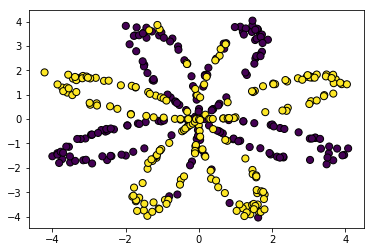

In [3]:
plt.scatter(X[0, :], X[1, :], c = Y, s = 50, edgecolors = "black")

## 简单Logistic Regression#
首先用简单的LR测试一下分类效果  
这里用到sklearn的LogisticRegression()

**LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=1)**

**Parameters:**	
**fit_intercept :** boolean, optional, default True  
whether to calculate the intercept for this model. If set to False, no intercept will be used in calculations (e.g. data is expected to be already centered).  
**normalize :** boolean, optional, default False  
This parameter is ignored when fit_intercept is set to False. If True, the regressors X will be normalized before regression by subtracting the mean and dividing by the l2-norm. If you wish to standardize, please use sklearn.preprocessing.StandardScaler before calling fit on an estimator with normalize=False.  
**copy_X :** boolean, optional, default True  
If True, X will be copied; else, it may be overwritten.  
**n_jobs :** int, optional, default 1  
The number of jobs to use for the computation. If -1 all CPUs are used. This will only provide speedup for n_targets > 1 and sufficient large problems.

In [4]:
LR = sklearn.linear_model.LogisticRegression()
LR.fit(X.T, Y.T)

E:\Anaconda\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [5]:
pred = LR.predict(X.T)
mask = pred == Y.T 
mask = mask * np.ones(Y.shape[1])
print("LR accurucy = ", np.mean(mask))

LR accurucy =  0.5


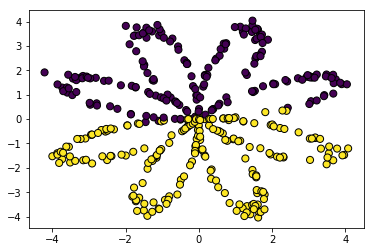

In [6]:
plt.scatter(X[0, :], X[1, :], c = pred, s = 50, edgecolors = "black")

可以看到简单的Logistic Regression准确率只有0.5左右，因为它只能处理线性可分问题，对于线性不可分问题无能为力

## 神经网络模型 #
神经网络模型通过激活函数来引入非线性  

**模型：**
<img src = "source/One hidden layer NN model.png"> </img>

**数学解释：**
对于每个样本 $x^{(i)}$:  
隐层神经元$z^{[1] (i)}$的值为：  
$$z^{[1] (i)} =  W^{[1]} x^{(i)} + b^{[1] (i)}$$  
对隐层神经元进行激活：  
$$a^{[1] (i)} = \tanh(z^{[1] (i)})$$  
输出层神经元值为：  
$$z^{[2] (i)} = W^{[2]} a^{[1] (i)} + b^{[2] (i)}$$  
对输出层神经元计算sigmoid函数：  
$$\hat{y}^{(i)} = a^{[2] (i)} = \sigma(z^{ [2] (i)})$$  
根据输出概率进行分类：  
$$y^{(i)}_{prediction} = \begin{cases} 1 & \mbox{if } a^{[2](i)} > 0.5 \\ 0 & \mbox{otherwise } \end{cases}$$  

最后计算损失 $J$ :   
$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large\left(\small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right)  \large  \right) \small $$  

### 网络搭建#
- 需要定义的变量：
    - 输入层的规模(对应训练数据的特征规模)
    - 隐层规模
    - 输出层的规模(对应输出的类别数)  
    
定义一个函数layer_sizes获取这些变量

In [31]:
def layer_sizes(X, Y):   
    n_x = X.shape[0]
    n_h = 4
    n_y = 1
    return (n_x, n_h, n_y)

In [8]:
X_assess, Y_assess = layer_sizes_test_case()
(n_x, n_h, n_y) = layer_sizes(X_assess, Y_assess)
print("The size of the input layer is: n_x = " + str(n_x))
print("The size of the hidden layer is: n_h = " + str(n_h))
print("The size of the output layer is: n_y = " + str(n_y))

The size of the input layer is: n_x = 5
The size of the hidden layer is: n_h = 4
The size of the output layer is: n_y = 2


### 参数初始化#
对于有隐层的神经网络，参数不能初始化为0，因为一旦参数初始化为0，所有神经元计算的值都为零，继而所有权重更新量相同，网络失效。
**要点：**
- 保证参数的shape争取
- 可以用np.random.randn(a,b) * 0.01来初始化，因为对于tanh激活，参数过大会使其导数逼近0，参数更新慢
- 对于偏置b，可以初始化为0

In [9]:
def initialize_parameters(n_x, n_h, n_y):
    np.random.seed(2)
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1))
    
    assert (W1.shape == (n_h, n_x))
    assert (b1.shape == (n_h, 1))
    assert (W2.shape == (n_y, n_h))
    assert (b2.shape == (n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [10]:
n_x, n_h, n_y = initialize_parameters_test_case()

parameters = initialize_parameters(n_x, n_h, n_y)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[-0.00416758 -0.00056267]
 [-0.02136196  0.01640271]
 [-0.01793436 -0.00841747]
 [ 0.00502881 -0.01245288]]
b1 = [[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]
W2 = [[-0.01057952 -0.00909008  0.00551454  0.02292208]]
b2 = [[ 0.]]


### 前向传播 #
根据上面的公式进行搭建  
- sigmoid()已经导入
- 激活函数可以用np.tanh()

In [29]:
def forward_propagation(X, parameters):
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]

    assert(X.shape[0] == W1.shape[1])
    
    Z1 = np.dot(W1, X) + b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)
    
    assert(A2.shape == (1, X.shape[1])),A2.shape
    
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache

In [46]:
X_assess, parameters = forward_propagation_test_case()
A2, cache = forward_propagation(X_assess, parameters)

print(np.mean(cache['Z1']) ,np.mean(cache['A1']),np.mean(cache['Z2']),np.mean(cache['A2']))

0.262818640198 0.091999045227 -1.30766601287 0.212877681719


### 损失计算 #
根据上面公式计算损失$J$  
**计算cross-entropy：**  
- 可以利用np.sum()与np.dot()计算(见上次练习)
- 可以利用公式$- \sum\limits_{i=0}^{m}  y^{(i)}\log(a^{[2](i)})$计算交叉熵(上面的J是本公式在2类的情况)  
    - logprobs = np.multiply(np.log(A2),Y)
    - cost = - np.sum(logprobs) 

In [13]:
def compute_cost(A2, Y, parameters):
    m = Y.shape[1] 

    logprobs = np.multiply(np.log(A2),Y)
    cost = - np.sum(logprobs)
    
    cost = np.squeeze(cost)      
                             
    assert(isinstance(cost, float))
    
    return cost

In [14]:
A2, Y_assess, parameters = compute_cost_test_case()

print("cost = " + str(compute_cost(A2, Y_assess, parameters)))

cost = 0.692685886972


### 反向传播 #
反向传播依据链式求导法则：  
<img src = "source/gradient descent.png"></img>  

对于tanh激活:  
$a = g^{[1]}(z)$  

$g^{[1]'}(z) = 1-a^2$   

所以计算$g^{[1]'}(Z^{[1]})$ 可以用公式：(1 - np.power(A1, 2))

In [15]:
def backward_propagation(parameters, cache, X, Y):

    m = X.shape[1]
    
    W1 = parameters["W1"]
    W2 = parameters["W2"]
        
    A1 = cache["A1"]
    A2 = cache["A2"]

    dZ2 = A2 - Y
    dW2 = np.dot(dZ2, A1.T) / m
    db2 = np.sum(dZ2, axis = 1, keepdims = True) / m
    dZ1 = np.dot(W2.T, dZ2) * (1 - np.power(A1, 2))
    dW1 = np.dot(dZ1, X.T) / m
    db1 = np.sum(dZ1, axis = 1, keepdims = True) / m
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads

In [16]:
parameters, cache, X_assess, Y_assess = backward_propagation_test_case()

grads = backward_propagation(parameters, cache, X_assess, Y_assess)
print ("dW1 = "+ str(grads["dW1"]))
print ("db1 = "+ str(grads["db1"]))
print ("dW2 = "+ str(grads["dW2"]))
print ("db2 = "+ str(grads["db2"]))

dW1 = [[ 0.00301023 -0.00747267]
 [ 0.00257968 -0.00641288]
 [-0.00156892  0.003893  ]
 [-0.00652037  0.01618243]]
db1 = [[ 0.00176201]
 [ 0.00150995]
 [-0.00091736]
 [-0.00381422]]
dW2 = [[ 0.00078841  0.01765429 -0.00084166 -0.01022527]]
db2 = [[-0.16655712]]


### 参数更新#
** 更新公式：**$ \theta = \theta - \alpha \frac{\partial J }{ \partial \theta }$  
注意选取合适的学习率$\alpha$，学习率过大会造成无法收敛，学习率过小收敛慢。

In [17]:
def update_parameters(parameters, grads, learning_rate = 1.2):

    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]

    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]

    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [18]:
parameters, grads = update_parameters_test_case()
parameters = update_parameters(parameters, grads)

print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[-0.00643025  0.01936718]
 [-0.02410458  0.03978052]
 [-0.01653973 -0.02096177]
 [ 0.01046864 -0.05990141]]
b1 = [[ -1.02420756e-06]
 [  1.27373948e-05]
 [  8.32996807e-07]
 [ -3.20136836e-06]]
W2 = [[-0.01041081 -0.04463285  0.01758031  0.04747113]]
b2 = [[ 0.00010457]]


### 模型整合#

In [23]:
def nn_model(X, Y, n_h, learning_rate = 1.2,num_iterations = 10000, print_cost = False):

    np.random.seed(3)
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[2]

    parameters = initialize_parameters(n_x, n_h, n_y)
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]

    for i in range(0, num_iterations):

        A2, cache = forward_propagation(X, parameters)

        cost = compute_cost(A2, Y, parameters)

        grads = backward_propagation(parameters, cache, X, Y)

        parameters = update_parameters(parameters, grads, learning_rate = learning_rate)

        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    return parameters

In [33]:
X_assess, Y_assess = nn_model_test_case()
parameters = nn_model(X_assess, Y_assess, 4, 1.2, num_iterations=10000, print_cost=True)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

Cost after iteration 0: 1.385354
Cost after iteration 1000: 0.000317
Cost after iteration 2000: 0.000158
Cost after iteration 3000: 0.000105
Cost after iteration 4000: 0.000079
Cost after iteration 5000: 0.000063
Cost after iteration 6000: 0.000053
Cost after iteration 7000: 0.000045
Cost after iteration 8000: 0.000040
Cost after iteration 9000: 0.000035
W1 = [[-0.65848169  1.21866811]
 [-0.76204273  1.39377573]
 [ 0.5792005  -1.10397703]
 [ 0.76773391 -1.41477129]]
b1 = [[ 0.287592  ]
 [ 0.3511264 ]
 [-0.2431246 ]
 [-0.35772805]]
W2 = [[-2.45566237 -3.27042274  2.00784958  3.36773273]]
b2 = [[ 0.20459656]]


### 预测 #
输出概率大于0.5预测为正例，否则为反例：$y_{prediction} = \mathbb 1 \text{{activation > 0.5}} = \begin{cases}
      1 & \text{if}\ activation > 0.5 \\
      0 & \text{otherwise}
    \end{cases}$  

In [47]:
def predict(parameters, X):

    A2, cache = forward_propagation(X, parameters)
    predictions = (A2 > 0.5) * np.ones(A2.shape)
    
    return predictions

In [48]:
parameters, X_assess = predict_test_case()

predictions = predict(parameters, X_assess)
print("predictions mean = " + str(np.mean(predictions)))

predictions mean = 0.666666666667


### 测试#

Cost after iteration 0: 138.613963
Cost after iteration 1000: 57.643326
Cost after iteration 2000: 50.677062
Cost after iteration 3000: 46.632785
Cost after iteration 4000: 45.276968
Cost after iteration 5000: 44.448380
Cost after iteration 6000: 43.847601
Cost after iteration 7000: 43.384818
Cost after iteration 8000: 39.822112
Cost after iteration 9000: 39.506154


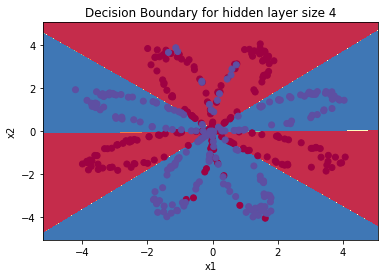

In [49]:
parameters = nn_model(X, Y, n_h = 4, num_iterations = 10000, print_cost=True)

plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(4))

In [55]:
pred = predict(parameters, X)
print("accurucy = ", np.mean((pred == Y) * np.ones(len(pred))))

accurucy =  0.905
